In [31]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [32]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [33]:
case = "case6ww"
case_type = 0
is_custom = False
net = custom_networks.get_case(case, case_type, is_custom)

In [34]:
# # parameters
# net.load["p_mw"] = net.load["p_mw"] / net.sn_mva
# net.load["q_mvar"] = net.load["q_mvar"] / net.sn_mva

# net.line["r_ohm_per_km"] = np.array((net.line['r_ohm_per_km'] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)
# net.line["x_ohm_per_km"] = np.array((net.line['x_ohm_per_km'] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)

# # bounds
# for col_name in ["max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]:
#     net.gen[col_name] = net.gen[col_name] / net.sn_mva
#     net.ext_grid[col_name] = net.ext_grid[col_name] / net.sn_mva


# net.bus["vn_kv"] = 1
# net.sn_mva = 1

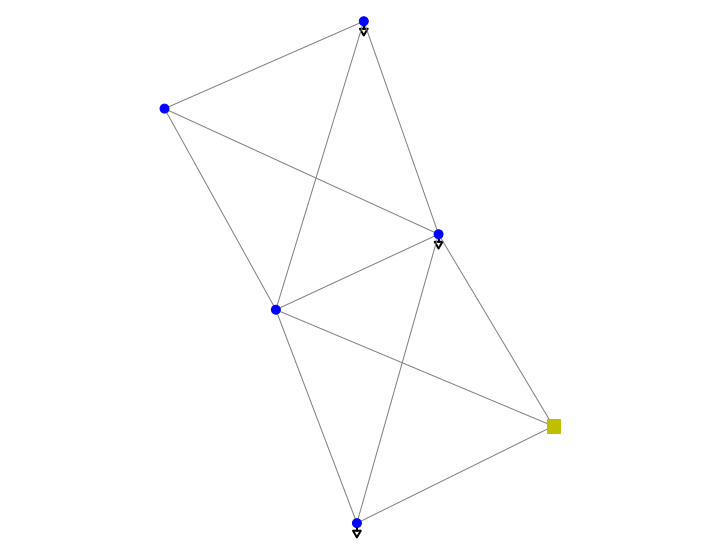

<AxesSubplot:>

In [35]:
simple_plot(net, plot_loads=True, plot_sgens=True)

In [36]:
n = len(net.bus)

#### Generators

In [37]:
gen_df_list = []
gen_name_list = ["ext_grid", "gen", "sgen"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [38]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,200.0,50.0,100.0,-100.0,ext_grid,213.1,11.669,0.00533,0.0,0.0,0.0
1,0,1,150.0,37.5,100.0,-100.0,gen,200.0,10.333,0.00889,0.0,0.0,0.0
2,1,2,180.0,45.0,100.0,-100.0,gen,240.0,10.833,0.00741,0.0,0.0,0.0


#### Bus loads

In [39]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [40]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,70.0,70.0
4,70.0,70.0
5,70.0,70.0


#### Admittance matrices

In [41]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

# np.array((net.line['r_ohm_per_km'] * net.line['length_km'] * net.sn_mva * 1e6 / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values * 1e3) ** 2)

In [42]:
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [43]:
G_row_sums = np.sum(G_val, axis=1)
B_row_sums = np.sum(B_val, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        # TODO: figure out how to compute from data
        g = shunt_row["p_mw"].to_numpy()[0]
        b = -shunt_row["q_mvar"].to_numpy()[0]  # FIXME: shunt susceptance is negative as in original data?
    G_val[i][i] = g - G_row_sums[i]
    B_val[i][i] = b - B_row_sums[i]

## Variables

In [44]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [45]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [46]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), nonneg=True, value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [47]:
# vectors of cost coefficients: c_[p or q]_[power]

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

## Constraints

### SOCP

In [120]:
X = cp.Variable((n,n), hermitian=True)
constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP

In [121]:
# constraints = [X >> 0]

In [122]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [123]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [124]:
# constraints += [ X[0][0] == 1 ]

In [125]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [126]:
p_cost = cp.sum(c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0))
q_cost = cp.sum(c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0))

In [127]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [128]:
prob.is_dcp()

True

In [129]:
prob.is_dpp()

True

In [130]:
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)

The optimal value is 3139.932789829798
A solution X is
[[1.1025    +0.j         1.1024891 -0.00490278j 0.        +0.j
  1.02996374+0.04706698j 1.0212231 +0.04669333j 0.        +0.j        ]
 [1.1024891 +0.00490278j 1.1025    +0.j         1.12347887+0.00689033j
  1.03091162+0.0161818j  1.02169593+0.03484702j 1.0494402 +0.01880481j]
 [0.        +0.j         1.12347887-0.00689033j 1.1449    +0.j
  0.        +0.j         1.04097347+0.0405307j  1.06852425+0.04798629j]
 [1.02996374-0.04706698j 1.03091162-0.0161818j  0.        +0.j
  0.96420917+0.j         0.95600524-0.00654487j 0.        +0.j        ]
 [1.0212231 -0.04669333j 1.02169593-0.03484702j 1.04097347-0.0405307j
  0.95600524+0.00654487j 0.94791554+0.j         0.97319337-0.01018636j]
 [0.        +0.j         1.0494402 -0.01880481j 1.06852425-0.04798629j
  0.        +0.j         0.97319337+0.01018636j 0.99925475+0.j        ]]


In [131]:
np.abs(np.linalg.eigvalsh(X.value))

array([8.60777354e-01, 2.27129299e-02, 1.68261176e-04, 2.29990007e-02,
       2.10472115e+00, 5.01688133e+00])

In [132]:
print(p_g.value)
print(q_g.value)

[[0.50000006]
 [0.79763403]
 [0.87885918]]
[[0.5100101 ]
 [0.82682433]
 [1.        ]]


In [133]:
prob.status

'optimal'

In [134]:
# sfm = SolutionFilesManager(folder, case, case_type, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

### Verify constraints with original solution

In [135]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")
_, V_orig, p_orig, q_orig = sfm.load_solution()

In [136]:
X_orig = V_orig @ V_orig.conjugate().reshape(1,-1)
print(X_orig)

[[1.1025    +0.j         1.1024441 +0.01110209j 1.12349988-0.00052581j
  1.02949809+0.03589763j 1.02068633+0.04266359j 1.04825874+0.03972497j]
 [1.1024441 -0.01110209j 1.1025    +0.j         1.12343762-0.01183933j
  1.02980738+0.02552885j 1.0210642 +0.0323832j  1.04860562+0.02916708j]
 [1.12349988+0.00052581j 1.12343762+0.01183933j 1.1449    +0.j
  1.04909034+0.03707238j 1.04010751+0.04396301j 1.06820651+0.04098157j]
 [1.02949809-0.03589763j 1.02980738-0.02552885j 1.04909034-0.03707238j
  0.96249883+0.j         0.95449084+0.00660486j 0.98014186+0.00296306j]
 [1.02068633-0.04266359j 1.0210642 -0.0323832j  1.04010751-0.04396301j
  0.95449084-0.00660486j 0.9465948 +0.j         0.97200741-0.00378752j]
 [1.04825874-0.03972497j 1.04860562-0.02916708j 1.06820651-0.04098157j
  0.98014186-0.00296306j 0.97200741+0.00378752j 0.99811742+0.j        ]]


In [137]:
print(p_orig)
print(q_orig)

[[0.50000046]
 [0.781591  ]
 [0.89633626]]
[[0.49852671]
 [0.83694744]
 [0.99999989]]


In [138]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("active %d"  %(i))
    print(np.sum([p_orig[k] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_orig[i][i] + np.sum([G_val[i][j] * np.real(X_orig[i][j]) + B_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))
    print("reactive %d"  %(i))
    print(np.sum([q_orig[k] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_orig[i][i] + np.sum([-B_val[i][j] * np.real(X_orig[i][j]) + G_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))

active 0
[0.50000046]
(0.5000004616085203+0j)
reactive 0
[0.49852671]
(0.4985267057430658+0j)
active 1
[0.781591]
(0.7815910047728156+0j)
reactive 1
[0.83694744]
(0.8369474424322227+0j)
active 2
[0.89633626]
(0.8963362629172567+0j)
reactive 2
[0.99999989]
(0.9999998934915482+0j)
active 3
[-0.7]
(-0.6999999999998581+0j)
reactive 3
[-0.7]
(-0.6999999999996334+0j)
active 4
[-0.7]
(-0.6999999999999051+0j)
reactive 4
[-0.7]
(-0.6999999999997666+0j)
active 5
[-0.7]
(-0.6999999999998989+0j)
reactive 5
[-0.7]
(-0.6999999999996973+0j)
